# Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn.utils.validation import check_is_fitted

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget -nv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

2022-10-18 02:21:03 URL:https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv [1423529/1423529] -> "housing.csv.1" [1]


In [3]:
#@ READING DATASET:
PATH = "housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [4]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 
               'median_income', 'ocean_proximity']
target = 'median_house_value_log'

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [5]:
df[target] = np.log1p(df.median_house_value.values)

In [6]:
def train_val_test_split(df, val_split=0.2, test_split=0.2, seed=None):

  # train_split = 1 - val_split - test_split

  # create splits
  df_full_train, df_test = train_test_split(df, test_size=test_split, random_state=seed)
  df_train, df_val = train_test_split(df_full_train, test_size=val_split/(1-test_split), random_state=seed)

  # return
  return (df_train, df_val, df_full_train, df_test)

In [7]:
df_train, df_val, df_full_train, df_test = train_val_test_split(df, seed=1)

- We will use `DictVectorizer` to turn train and validation into matrices.

In [8]:
def one_hot_encoding(dv, df, features, target):

  feat_dict = df[features].to_dict(orient='records')
  
  try:
    check_is_fitted(dv, attributes='feature_names_')
  except NotFittedError as e:
    dv.fit(feat_dict)
  
  X = dv.transform(feat_dict)
  y = df[target].values

  return (X, y)

In [9]:
dv = DictVectorizer(sparse=False)

X_train, y_train = one_hot_encoding(dv, df_train, features, target)
X_val, y_val = one_hot_encoding(dv, df_val, features, target)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [10]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/user/.cache/pypoetry/virtualenvs/ml-zoomcamp-djmS9_l--py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer: `ocean_proximity=INLAND`

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [15]:
#@ TRAINING RANDOM FOREST MODEL:
dt = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
dt.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = dt.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False) # squared=False => RMSE, squared=True => MSE
    
print('%.2f' % (rmse))

0.25


- What's the RMSE of this model on validation?

- Answer: `0.25`

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [17]:
#@ TRAINING THE RANDOM FOREST MODEL:
n_estimators = np.arange(10, 201, step=10)

for n_estimator in n_estimators: 
    dt = RandomForestRegressor(n_estimators=n_estimator, random_state=1, n_jobs=-1)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False) # squared=False => RMSE, squared=True => MSE
    
    print('%4s -> %.3f' % (n_estimator, rmse))


  10 -> 0.246
  20 -> 0.239
  30 -> 0.236
  40 -> 0.235
  50 -> 0.233
  60 -> 0.233
  70 -> 0.232
  80 -> 0.232
  90 -> 0.232
 100 -> 0.232
 110 -> 0.232
 120 -> 0.232
 130 -> 0.232
 140 -> 0.232
 150 -> 0.232
 160 -> 0.232
 170 -> 0.232
 180 -> 0.232
 190 -> 0.232
 200 -> 0.232


- After which value of `n_estimators` does RMSE stop improving?

- Answer: `n_estimators = 70`

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [18]:
parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':np.arange(10, 201, step=10)}
rf = RandomForestRegressor(random_state=1, n_jobs=-1)
clf = GridSearchCV(rf, parameters, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             param_grid={'max_depth': [10, 15, 20, 25],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
             scoring='neg_root_mean_squared_error')

In [49]:
columns = list(clf.cv_results_['params'][0].keys()) + ['rmse']
scores = []

for i in range(len(clf.cv_results_['mean_test_score'])):
    scores.append(tuple(list(clf.cv_results_['params'][i].values()) + [clf.cv_results_['mean_test_score'][i]]))

df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])

<AxesSubplot: xlabel='None-max_depth', ylabel='n_estimators'>

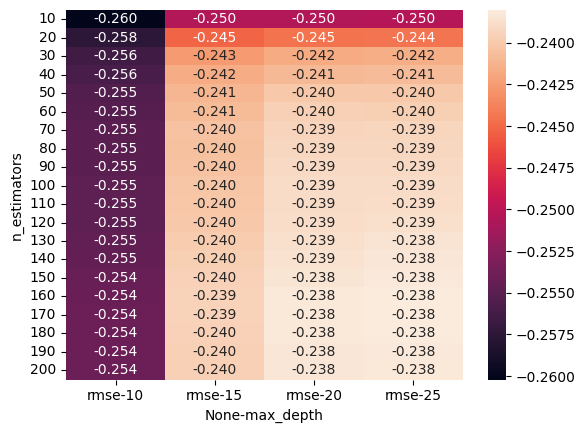

In [48]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
# higher values (lighter color) are better

In [50]:
#@ TRAINING THE MODEL WITH DEPTH:
n_estimators = np.arange(10, 201, step=10)
depths = [10, 15, 20, 25]
scores = []

for depth in depths:
    for n_estimator in n_estimators: 
    
        dt = RandomForestRegressor(n_estimators=n_estimator, max_depth=depth, random_state=1, n_jobs=-1)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        scores.append((depth, n_estimator, rmse))

<AxesSubplot: xlabel='None-max_depth', ylabel='n_estimator'>

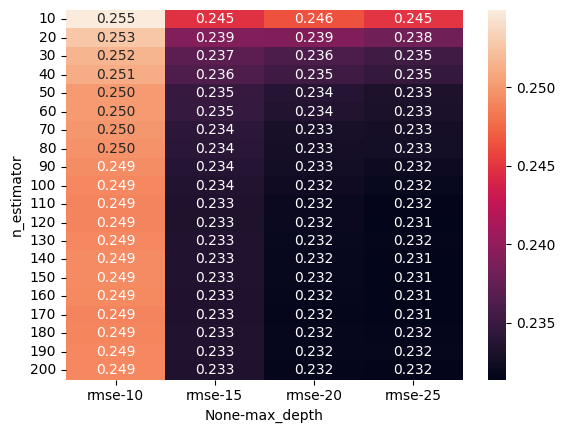

In [51]:
columns = ['max_depth', 'n_estimator', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='n_estimator', columns=['max_depth'], values=['rmse'])

sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
# lower values (darker color) are better

- What's the best `max_depth`:

- Answer: `25`

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [52]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [53]:
dict(zip(dv.get_feature_names_out(), rf.feature_importances_))

{'households': 0.01707949729751655,
 'housing_median_age': 0.03293146678518498,
 'latitude': 0.10154547618368868,
 'longitude': 0.09632464688219677,
 'median_income': 0.36366102999455063,
 'ocean_proximity=<1H OCEAN': 0.0028781968739456333,
 'ocean_proximity=INLAND': 0.3109008414649182,
 'ocean_proximity=ISLAND': 0.000356806262945808,
 'ocean_proximity=NEAR BAY': 0.000421521148856216,
 'ocean_proximity=NEAR OCEAN': 0.0042237262548374226,
 'population': 0.029629759818677763,
 'total_bedrooms': 0.018239616242627415,
 'total_rooms': 0.021807414790053964}

- What's the most important feature?

- Answer: `median_income`

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [54]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [61]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
results = {}

etas = [0.3, 0.1]

for eta in etas:

    evals_result = {}

    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                        evals=watchlist, evals_result=evals_result, verbose_eval=None)

    results[eta] = list(evals_result['val'].values())[0]


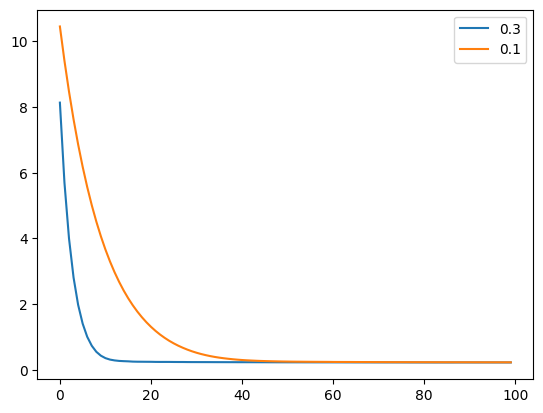

In [65]:
for eta, scores in results.items():
    plt.plot(scores, label=eta)

plt.legend()

Now change `eta` from `0.3` to `0.1`.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: `0.3`